# Curbing Chicago Car Crashes

**Authors:** Carlos McCrum, Michael Lee, Doug Mill
***

## Overview

Our task is to build inferential classification models for the Vehicle Safety Board of Chicago. We cleaned and formatted our data provided by the City of Chicago containing crashes,  vehicles and people relating to crashes from 2016 to 2020, we then modeled the primary contributory causes of car accidents into two categories. We used an iterative modeling approach and incorporated several classification models to see if we could find what crashes were preventable. Our recommendations include investing in driver education for certain age groups and fixing certain road conditions that could cause a crash. 
***

## Business Problem

Vehicle Safety Board wants to know if they should spend more funding in drivers education or fixing roads. Determining whether a crash is preventable and how to allocate funds to limit the number of crashes to present to the Vehicle Safety Board of Chicago.


***

## Data Understanding

Our stakeholder is the Vehicle Safety Board of Chicago. They are launching a new campaign to reduce car crashes. Our task is to build an inferential model to find out  which crashes were preventable and not. We labeled ‘Preventable’ as crashes that could have easily been avoided. Not following traffic laws and negligent driving would fall under this category. ‘Less Preventable’ are crashes that would require a substantial amount of money, time, and labor to fix. Bad road conditions, vision obscurity, and bad weather conditions would fall under this category.
***

##### Start by importing necessary packages. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

***

## Data Loading

Import data previously cleaned with only the relevant columns we need for our analysis. Our variable is a binary target that points to the contributory cause of the crash either being preventable or non-preventable.

***


Import our cleaned dataframe we cleaned previously. 

In [2]:
main_df = pd.read_csv('data/cleaned_data/cleaned_modeling_data.csv')
# Remove Bad Weather as it was too highly correlated with Bad Road Conditions
columns_to_drop = ['Unnamed: 0', 'BAD_WEATHER']
main_df.drop((columns_to_drop), axis = 1, inplace = True)

Check to see if we have a class imbalance. 

In [3]:
main_df['Target'].value_counts(normalize = True)

0    0.754374
1    0.245626
Name: Target, dtype: float64

Check correlations with our target

In [19]:
# sns.set(rc={'figure.figsize':(20, 20)})
# sns.heatmap(main_df.corr().abs(),annot=True);


## Data Modeling
We modeled the data through iterative modeling. We used a logistic regression model as our first simple model. For our second model, we created a Decision Tree Classifier that scored slightly better than our simple model. We used a RFE to determine the most important features and iterated with GridSearch to find the best parameters. Lastly, we used a XGBoost classifier with GridSearchCV to find the best model.
***

## Simple Model - Logistic Regression

To run our first simple model we start off by dropping irrelevant columns. 

In [5]:
columns_to_drop = ['CRASH_RECORD_ID','CRASH_DATE', 'LONGITUDE', 'LATITUDE', 'Target']

Split our data with train test split 

In [6]:
X = main_df.drop((columns_to_drop), axis=1)
y = main_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.7466465015648959

Because our class balance is 3:1, we are not going to SMOTE the minority class.

## Using RFE to select the most important columns

In [12]:
dt = DecisionTreeClassifier()
num_features_to_select = 5
use_RSE = True

select = RFE(dt, n_features_to_select=num_features_to_select)
select.fit(X = X_train, y = y_train)

keep_list = [(k,v) for k,v in zip(main_df.drop((columns_to_drop), axis=1).columns,select.support_)]
keep_string = ''
for k,v in keep_list:
    if v:
        keep_string += k + ','
if use_RSE == False:
    keep_list = formula_string.split('+')
keep_string = keep_string[:-1]

keep_string

'BAD_VISIBILITY,BAD_TRAFFIC,BAD_ROAD_CONDITION,DEFECT_ROAD,WORKING_TRAFFIC_DEVICE'

In [13]:
X = main_df[['BAD_ROAD_CONDITION','DEFECT_ROAD','WORKING_TRAFFIC_DEVICE','OBSCURED_VIZ','DRIVER_ERROR']]
y = main_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

dt_rfe = DecisionTreeClassifier(random_state = 42)
dt_rfe.fit(X_train, y_train)
dt_rfe.score(X_test, y_test)

0.7555023420925494

In [14]:
X = main_df.drop((columns_to_drop), axis = 1)
y = main_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

dt = DecisionTreeClassifier(random_state = 42)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.7563467557291995

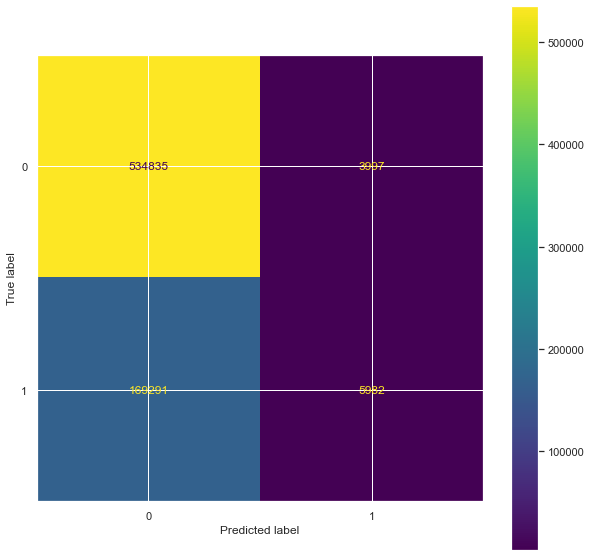

In [18]:
sns.set(rc={'figure.figsize':(10, 10)})
plot_confusion_matrix(dt, X_train, y_train)
plt.grid('OFF');

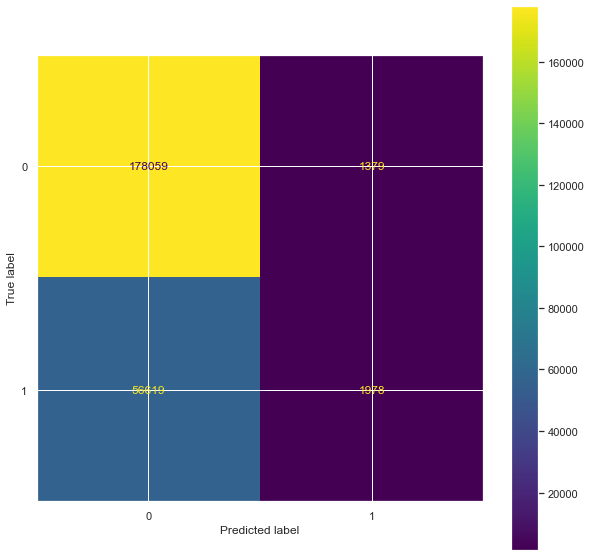

In [16]:
plot_confusion_matrix(dt, X_test, y_test);

# Grid Search

Because Decision Trees gave us the best accuracy score, we decided to try and find the best parameters
Using Grid Search to find the best parameters

In [20]:
# Look through max depth, min samples split, min sample leaf to find the best perameters. 
grid = [{'max_depth': [4, 6, 8], 
         'min_samples_split': [5, 10, 15], 
         'min_samples_leaf': [20, 25, 30]}]
GS = GridSearchCV(estimator=dt, 
                          param_grid=grid, 
                          scoring='recall', 
                          cv=5)

Fit to our grid

In [140]:
GS.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'max_depth': [4, 6, 8],
                          'min_samples_leaf': [20, 25, 30],
                          'min_samples_split': [5, 10, 15]}],
             scoring='recall')

- Analyze the results

In [141]:
GS.cv_results_

{'mean_fit_time': array([0.2447485 , 0.24604931, 0.26230397, 0.25861583, 0.24504924,
        0.26130981, 0.29262919, 0.32643795, 0.27138014, 0.34458575,
        0.34264293, 0.34032536, 0.3376245 , 0.33871341, 0.34239502,
        0.36982017, 0.35815492, 0.3525671 , 0.40582809, 0.3998384 ,
        0.38398399, 0.40741863, 0.42419848, 0.41262202, 0.41620736,
        0.41063604, 0.40554047]),
 'std_fit_time': array([0.00214896, 0.00663728, 0.02088562, 0.01942095, 0.0040863 ,
        0.01419883, 0.03309763, 0.01705002, 0.0085237 , 0.00867417,
        0.00853743, 0.00638358, 0.00443393, 0.00306203, 0.00472789,
        0.02413453, 0.02094852, 0.01987518, 0.00692623, 0.02138009,
        0.0191504 , 0.03735162, 0.02433384, 0.0238465 , 0.01979958,
        0.01947908, 0.01564996]),
 'mean_score_time': array([0.03949442, 0.04009309, 0.0412899 , 0.03969393, 0.03979497,
        0.04168835, 0.06382971, 0.04908423, 0.04258776, 0.04757447,
        0.04328775, 0.0420907 , 0.04279504, 0.04298682, 0.043084

- Find our best score

In [142]:
GS.best_estimator_.score(X_test, y_test)

0.7563425546663306

- See what the best perameters are

In [144]:
GS.best_params_

{'max_depth': 8, 'min_samples_leaf': 25, 'min_samples_split': 5}

## XGBoost

- Initiate XGBClassifier, fit, and determine the training and validation scores. 

In [ ]:
clf = XGBClassifier(eval_metric='mlogloss')
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

In [ ]:
param_grid = {
    'learning_rate': [0.2, 0.5],
    'max_depth': [6],
    'min_child_weight': [1],
    'subsample': [0.7],
    'n_estimators': [100],[200]
}

In [ ]:

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

## Results

The results of our model indicated that most of the crashes were Preventable. By spending more money on drivers education in ages 20 - 39, we could curb the total accidents in Chicago drastically.

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions

We recommend investing in online drivers education because this could significantly lower the amount of preventable crashes in the Chicago area. We recommend driver education because it is affordable, easy to implement, and saves a lot more in labor costs vs. repairing all the roads in Chicago.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***